In [116]:
show_plots = True

In [117]:
# Imports
import sys
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries
from shapely.ops import unary_union
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
import osmnx as ox
import numpy as np
import os
import matplotlib.pyplot as plt
# quetzal-specific stuff
from syspy.spatial.graph.graphbuilder import GraphBuilder, OsmnxCleaner
from syspy.spatial.graph import graphbuilder
from quetzal.io.gtfs_reader import importer
from quetzal.model import stepmodel
from datetime import datetime

In [118]:
training_folder = './../../'
input_path = training_folder + 'input/'
input_folder = training_folder + 'inputs/'
model_path = './../../model/'

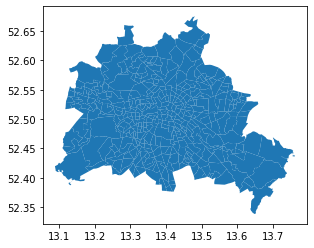

In [119]:
# Load the model with ber_zones
sm = stepmodel.read_json(model_path + 'zones')
if not type(sm.zones) == GeoDataFrame:
    sm.zones = GeoDataFrame(sm.zones, crs=sm.epsg)
if show_plots: sm.zones.plot()

## Road network

Build the road network graph from OpenStreetMap data and save it into GeoDataFrames

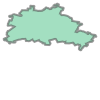

In [120]:
# To-Do think whether it might make sense to increase the buffer to cover Brandenburg
hull = unary_union([x.buffer(1e-3) for x in sm.zones['geometry']])
hull

In [121]:
# Download roads from OpenStreetMap (online) and save it in a graph
# using the OSMNX library
drive = ox.graph_from_polygon(hull, network_type='drive')
# Plot it
if show_plots: ox.plot_graph(drive)

In [ ]:
# Use OSMNX function to create GeoDataFrames from graph
road_nodes, road_links = ox.graph_to_gdfs(drive)

In [ ]:
# Let's have a look at the results
road_nodes.head(2)

y          x  street_count  ref highway  \
osmid                                                     
172539  52.565205  13.335501             3  NaN     NaN   
172545  52.567033  13.346605             4  NaN     NaN   

                         geometry  
osmid                              
172539  POINT (13.33550 52.56521)  
172545  POINT (13.34661 52.56703)

In [ ]:
#road_links.plot(figsize=(16,9))
road_links.head(2)

osmid lanes             name    highway maxspeed  \
u      v        key                                                       
172539 34694265 0    4610047     2  Holländerstraße   tertiary       50   
       34694336 0    5117633     2   Gotthardstraße  secondary       50   

                     oneway   length  \
u      v        key                    
172539 34694265 0     False  237.653   
       34694336 0     False  687.484   

                                                              geometry  ref  \
u      v        key                                                           
172539 34694265 0    LINESTRING (13.33550 52.56521, 13.33560 52.565...  NaN   
       34694336 0    LINESTRING (13.33550 52.56521, 13.33565 52.565...  NaN   

                    bridge width tunnel junction access service area est_width  
u      v        key                                                             
172539 34694265 0      NaN   NaN    NaN      NaN    NaN     NaN  NaN       NaN  
       34694336 0      NaN   NaN    NaN      NaN    NaN     NaN  NaN       NaN

In [ ]:
# Check if the columns you want to use later are in the columns above.
# If they appear as index names (printed bold), use the reset_index()
# function to create a new Data

In [ ]:
road_nodes = road_nodes.reset_index()
road_links = road_links.reset_index()

In [ ]:
# Rename columns and make them type string for later operations
road_links.rename(columns={'u': 'from', 'v': 'to'}, inplace=True)
road_nodes['osmid'] = road_nodes['osmid'].astype(str)
road_nodes = road_nodes.set_index('osmid')[['geometry']]
road_links[['from', 'to']] = road_links[['from', 'to']].astype(str)

In [ ]:
# We can drastically reduce the disc space needed for this table by
# reducing the complexity of LineString geometries.
# For our purpose it is enough to have the start and end point of a link.
# Let's write a function
def simplify_link(g):
    l = list(g.coords)
    return LineString([l[0], l[-1]])
# Apply the function to all our links
road_links['geometry'] = road_links['geometry'].apply(simplify_link)

In [ ]:
# Create a cleaner object and run cleaning functions on it
oc = OsmnxCleaner(
    road_links, 
    road_nodes, 
    a='from', 
    b='to'
)

In [ ]:
oc.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False # the boolean has been stored as a string    
)
#oc.clean_geometries() # Doesn't work, but let's hope we don't need it
oc.fix_nodeset_consistency()

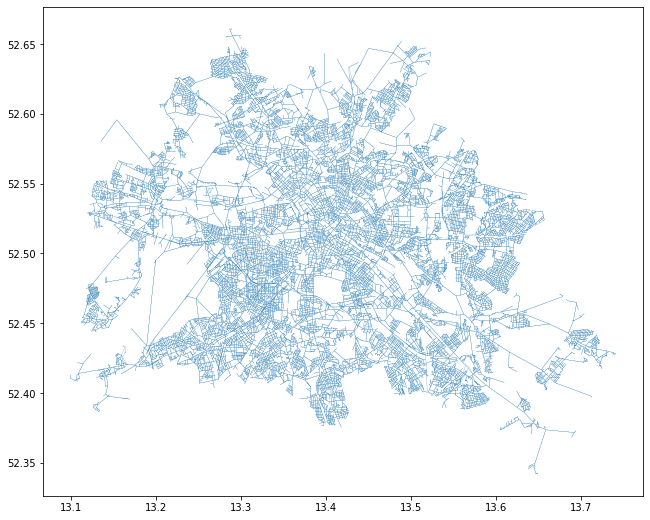

In [ ]:
if show_plots: road_links.plot(figsize=(16,9), linewidth=0.2)

Our road network is now saved in `oc.nodes` and `oc.links`

## Public Transport

For PT, we need to convert GTFS feeds into links and nodes GeoDataFrames

In [ ]:
# Load the GTFS feed
full_feed = importer.GtfsImporter(path='../../input/vbb_gtfs.zip', dist_units='m')
# downloaded from http://vbb.de/vbbgtfs
#print(full_feed.stops)

In [ ]:
# Restrict the feed to a given date in order to analyse a
# typical work day and not the whole week
start = min(full_feed.calendar['start_date'])
end = max(full_feed.calendar['end_date'])
feed_r = full_feed.restrict(
    dates=[start,start] # the dates must be within the feed start and end dates
)

In [ ]:
feed_r.calendar_dates

service_id      date exception_type
0           685  20220909              1
1          1436  20220909              1
2           401  20220909              1
3          1584  20220909              1
4           179  20220909              1
...         ...       ...            ...
1291       1501  20220909              1
1292       1770  20220909              1
1293         93  20220909              1
1294       1033  20220909              1
1295       1919  20220909              1

[1296 rows x 3 columns]

In [ ]:
# We can also restrict it to hours
# TODO: nothing between 8 and 9 am?
time_range = ['16:00:00', '17:00:00']
feed_t = feed_r.restrict(time_range=time_range)
# print(feed_t.stops)

In [ ]:
# And we can restrict it spacially if we write a suitable function
def spatial_restrict(feed, polygon, how='inner'):
    f = feed.copy()
    stops = f.stops.copy()
    stops['geometry'] = stops.apply(
        lambda r: geometry.Point([r['stop_lon'], r['stop_lat']]),
        axis=1
    )
    stops['included'] = stops['geometry'].apply(lambda g: polygon.contains(g))
    f.stops = f.stops.loc[stops['included'] == True]

    # relations
    f.stop_times = f.stop_times.loc[f.stop_times['stop_id'].isin(f.stops['stop_id'])]
    f.transfers = f.transfers.loc[f.transfers['from_stop_id'].isin(f.stops['stop_id'])]
    f.transfers = f.transfers.loc[f.transfers['to_stop_id'].isin(f.stops['stop_id'])]
    relevant_trips = (f.stop_times['trip_id'])
    f = f.restrict(trip_ids=relevant_trips)
    if how == 'inner':
        return f
    else:
        return feed.restrict(trip_ids=relevant_trips)

In [ ]:
# Give the hourly restricted feed to the spatial restriction
feed_s = spatial_restrict(feed_t, polygon=hull, how='inner')

In [ ]:
feed_s.calendar_dates[feed_s.calendar_dates['service_id']=='2']

service_id      date exception_type
565           2  20220909              1
1213          2  20220909              1

In [ ]:
feed_s.calendar_dates[feed_s.calendar_dates['service_id']=='1384']

service_id      date exception_type
623        1384  20220909              1
1271       1384  20220909              1

In [ ]:
dict = {}
for i in range(len(feed_s.calendar_dates['service_id'])):
    id = feed_s.calendar_dates['service_id'].iloc[i]
    if id in dict.keys():
        dict[id] += 1
    else:
        dict[id] = 1
print(any([dict[key]>1 for key in  dict.keys()]), dict)

True {'179': 2, '256': 2, '49': 2, '1419': 2, '154': 2, '554': 2, '1742': 2, '470': 2, '1881': 2, '720': 2, '680': 2, '296': 2, '514': 2, '1827': 2, '523': 2, '1356': 2, '255': 2, '482': 2, '760': 2, '1569': 2, '1175': 2, '178': 2, '251': 2, '406': 2, '547': 2, '755': 2, '1663': 2, '1361': 2, '545': 2, '1608': 2, '1591': 2, '94': 2, '993': 2, '1051': 2, '50': 2, '1669': 2, '990': 2, '1365': 2, '1878': 2, '525': 2, '932': 2, '153': 2, '1172': 2, '821': 2, '1766': 2, '1588': 2, '1582': 2, '371': 2, '718': 2, '346': 2, '38': 2, '1621': 2, '182': 2, '1359': 2, '686': 2, '713': 2, '127': 2, '315': 2, '1181': 2, '1756': 2, '1580': 2, '180': 2, '176': 2, '177': 2, '44': 2, '1344': 2, '1875': 2, '1779': 2, '66': 2, '1618': 2, '253': 2, '2': 2, '98': 2, '1900': 2, '1717': 2, '892': 2, '1724': 2, '25': 2, '1397': 2, '1384': 2, '511': 2, '589': 2, '1033': 2}


In [ ]:
# keep only first occurence of service_id by filtering calendar_dates
bool_indices = [x not in list(feed_s.calendar_dates['service_id'].iloc[0:n]) for n, x in enumerate(feed_s.calendar_dates['service_id'])]
feed_s.calendar_dates = feed_s.calendar_dates[bool_indices]


In [ ]:
dict = {}
for i in range(len(feed_s.calendar_dates['service_id'])):
    id = feed_s.calendar_dates['service_id'].iloc[i]
    if id in dict.keys():
        dict[id] += 1
    else:
        dict[id] = 1
print(any([dict[key]>1 for key in  dict.keys()]), dict)

False {'179': 1, '256': 1, '49': 1, '1419': 1, '154': 1, '554': 1, '1742': 1, '470': 1, '1881': 1, '720': 1, '680': 1, '296': 1, '514': 1, '1827': 1, '523': 1, '1356': 1, '255': 1, '482': 1, '760': 1, '1569': 1, '1175': 1, '178': 1, '251': 1, '406': 1, '547': 1, '755': 1, '1663': 1, '1361': 1, '545': 1, '1608': 1, '1591': 1, '94': 1, '993': 1, '1051': 1, '50': 1, '1669': 1, '990': 1, '1365': 1, '1878': 1, '525': 1, '932': 1, '153': 1, '1172': 1, '821': 1, '1766': 1, '1588': 1, '1582': 1, '371': 1, '718': 1, '346': 1, '38': 1, '1621': 1, '182': 1, '1359': 1, '686': 1, '713': 1, '127': 1, '315': 1, '1181': 1, '1756': 1, '1580': 1, '180': 1, '176': 1, '177': 1, '44': 1, '1344': 1, '1875': 1, '1779': 1, '66': 1, '1618': 1, '253': 1, '2': 1, '98': 1, '1900': 1, '1717': 1, '892': 1, '1724': 1, '25': 1, '1397': 1, '1384': 1, '511': 1, '589': 1, '1033': 1}


In [ ]:
# GTFS feeds are very complex. Have a look at Wikipedia for its structure
# We neet to perform some operations in order to transform it into a graph
feed = feed_s.copy()
feed.group_services()
#feed.build_stop_clusters(distance_threshold=300) # clusterize stops
feed.build_patterns(on='stop_id') # use on='cluster_id' if you built clusters


In [ ]:
feed_frequencies = feed.convert_to_frequencies(time_range=time_range)

100%|██████████| 707/707 [00:11<00:00, 62.58it/s]


In [ ]:
# We can build links and nodes now from the frequency graph
feed_frequencies.build_links_and_nodes()
feed_frequencies.build_geometries(use_utm=False)

export geometries in epsg: 32633


In [ ]:
feed_frequencies.links.head(2)

index                        a      trip_id  link_sequence  departure_time  \
0      0  de:11000:900092201:1:51  10141_109_0              1         54498.0   
1      1  de:11000:900093201:1:51  10141_109_0              2         54654.0   

   pickup_type                        b  arrival_time  drop_off_type   time  \
0            0  de:11000:900093201:1:51       54630.0              0  132.0   
1            0  de:11000:900094101:1:51       54768.0              0  114.0   

   ...  wheelchair_accessible bikes_allowed agency_id route_short_name  \
0  ...                      1             1         1     S1-10141_109   
1  ...                      1             1         1     S1-10141_109   

  route_long_name route_type  route_color route_text_color route_desc  \
0             NaN        109          NaN              NaN        NaN   
1             NaN        109          NaN              NaN        NaN   

                                            geometry  
0  LINESTRING (13.29032 52.63226, 13.30762 52.61729)  
1  LINESTRING (13.30762 52.61729, 13.32109 52.60626)  

[2 rows x 29 columns]

In [ ]:
feed_frequencies.nodes.head(1)

stop_id stop_code                     stop_name stop_desc  \
27  de:11000:900160004:3:54       NaN  S+U Lichtenberg Bhf (Berlin)       NaN   

    location_type      parent_station  wheelchair_boarding platform_code  \
27              0  de:11000:900160004                    0            17   

                              zone_id  level_id                   geometry  
27  5656_S+U_Lichtenberg_Bhf_(Berlin)     100.0  POINT (13.49649 52.51000)

In [ ]:
# Make stop_id the unique index of nodes
# Use cluster_id if you built clusters before
feed_frequencies.nodes.set_index('stop_id', inplace=True)
len(feed_frequencies.nodes.loc[feed_frequencies.nodes.index.duplicated()])

0

In [ ]:
feed_frequencies.links['route_type'].unique()

array([ 109,  700,  900,  100, 1000,  400,    2], dtype=int64)

In [ ]:
# Rename the route types
mapping = {0:'tram', 1:'subway', 2:'rail', 3:'bus',
    4:'ferry', 5:'cable_car', 6:'gondola', 7:'funicular'}
#Additional route types used in VBB Data:
ex_mapping = {100:'rail', 109:'rail', 400:'subway', 700:'bus', 900:'tram', 1000:'ferry'}
mapping.update(ex_mapping)

feed_frequencies.links['route_type'] = feed_frequencies.links['route_type'].apply(
    lambda t: mapping.get(t, t)
)

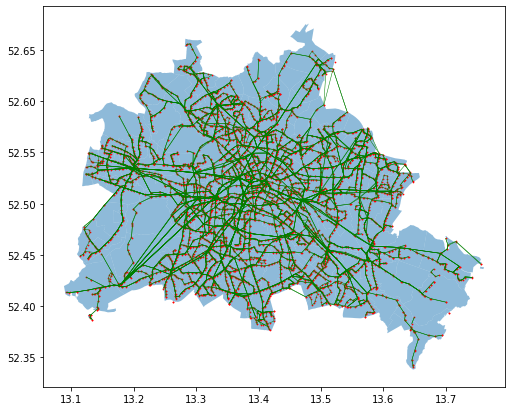

In [ ]:
if show_plots:
    # Plot the results using matplotlib notation
    ax = sm.zones.plot(alpha=0.5, figsize=[17, 7])
    ax = feed_frequencies.links.plot(linewidth=0.5, color='green', ax=ax)
    plot= feed_frequencies.nodes.plot(markersize=0.5, color='red', ax=ax)

## Create the transport model

We have the network DataFrames and need to put them into a model now, to be able to run quetzal functions on it, that go beyond the scope of only one DataFrame

In [ ]:
# Add road network
sm.road_links = oc.links[['a', 'b', 'length', 'geometry', 'highway', 'maxspeed']]
sm.road_nodes = oc.nodes[['geometry']]

In [ ]:
# Assign PT network to it with the columns we need
sm.links = feed_frequencies.links[['trip_id', 'a', 'b', 'link_sequence', 'time', 'headway',
                                   'pattern_id', 'route_id', 'service_id', 'direction_id',
                                   'agency_id', 'route_type', 'route_color', 'geometry']]
sm.nodes = feed_frequencies.nodes[['geometry', 'stop_name', 'location_type']]

## Check integrity

Run quetzals integrity check functions to see if the networks are alright

In [ ]:
# check and fix name collision in the indicies
sm.integrity_fix_collision()

can not add prefixes on table:  footpaths


In [ ]:
sm.integrity_fix_road_network(cutoff=10, recursive_depth=5)

direct: 28141it [00:13, 2095.81it/s]
reversed: 28141it [00:12, 2302.80it/s]
28086it [00:10, 2799.14it/s]


In [ ]:
# Fix PT
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_collision()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()
sm.integrity_fix_nodeset_consistency()

dropped circular lines: ['17295_700_3', '17292_700_1', '19042_100_6', '17421_900_2', '17538_700_0', '17346_700_1', '17329_700_0', '17375_700_0', '17382_700_1', '17348_700_3', '17345_700_1', '19049_100_3', '17292_700_0', '19049_100_5', '17348_700_2', '17531_700_0', '17372_700_0', '17413_700_0', '17328_700_1', '17427_900_2', '17295_700_0', '19019_700_0', '19043_100_6', '17385_700_1', '17346_700_0', '17453_700_1', '17619_700_1', '17318_700_2']


In [ ]:
# Test
sm.integrity_test_all(errors='raise')

passed: integrity_test_circular_lines
passed: integrity_test_collision


28086it [00:02, 10304.45it/s]


passed: integrity_test_dead_ends
passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency


28086it [00:10, 2754.29it/s]


passed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences


## Cluster PT stops

Clustering has the advantage of reducing the model's file size and computational expenses. You can also leaf this step out.
To-Do: is n_clusters = 300 the best number?

In [ ]:
# Clusterize nodes
sm.preparation_clusterize_nodes(n_clusters=800)
sm.nodes.head(1)

geometry
cluster                                            
0        POINT (13.4371566040877 52.53193737248301)

In [ ]:
len(sm.nodes)

800

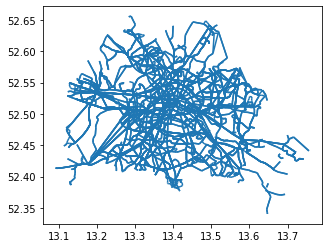

In [ ]:
if show_plots: sm.links.plot()

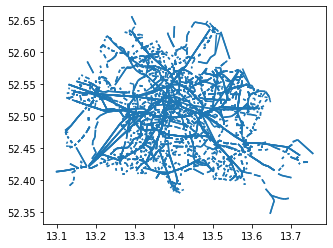

In [ ]:
# Now, some links might go from one stop to the same # To-Do: This does seem to remove to many links. Check back later if this is problematic.
sm.links = sm.links.loc[sm.links['a']!=sm.links['b']]
if show_plots: sm.links.plot()

In [ ]:
# Fix network integrity again
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_collision()

dropped circular lines: ['17325_700_0', '17366_700_0', '17369_700_1', '17535_700_1', '17324_900_1', '17366_700_2', '17412_700_0', '17303_700_1', '17368_700_4', '23568_700_0', '17347_700_0', '17298_700_0', '17310_700_1', '17343_700_1', '17399_700_0', '17369_700_2', '17344_700_0', '17368_700_3', '23567_700_3', '17376_700_0', '23568_700_1', '17347_700_3', '17368_700_0', '17538_700_1', '17402_700_0', '17303_700_2', '17415_700_0', '17315_700_0', '17349_700_1', '17355_700_2', '17355_700_0', '17310_700_0', '17349_700_2', '17343_700_0', '17401_700_1', '17438_900_3', '23567_700_2', '17310_700_2', '17447_700_0', '17344_700_1', '17349_700_0', '17310_700_3', '17422_900_1', '17392_700_0', '17438_900_1', '17321_700_0', '17321_700_1', '17535_700_0', '17324_900_0', '4242_700_1', '17368_700_1', '17370_700_0', '4242_700_0', '17349_700_3', '17422_900_3', '17360_700_0', '17383_700_1', '17355_700_1', '17347_700_2', '17352_900_0', '23567_700_0', '17422_900_2', '17317_700_0', '17325_700_1', '17315_700_2', '1

In [ ]:
# Check the integrity again
sm.integrity_test_all(errors='raise')

passed: integrity_test_circular_lines
passed: integrity_test_collision


28086it [00:02, 9831.67it/s] 


passed: integrity_test_dead_ends
passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency


28086it [00:10, 2789.04it/s]


passed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences


In [ ]:
print(sorted([str(key)+": "+str(type(sm.__dict__[key]).__name__) for key in sm.__dict__.keys()]))

['broken_sequences: list', 'centroids: GeoDataFrame', 'checkpoint_links: GeoDataFrame', 'checkpoint_nodes: GeoDataFrame', 'circular_lines: list', 'coordinates_unit: str', 'dead_ends: list', 'debug: bool', 'disaggregated_nodes: GeoDataFrame', 'epsg: int', 'fare_attributes: DataFrame', 'fare_rules: DataFrame', 'footpaths: GeoDataFrame', 'jsons: DataFrame', 'lines: GeoDataFrame', 'links: GeoDataFrame', 'loaded_links: GeoDataFrame', 'loaded_nodes: GeoDataFrame', 'logit_scales: DataFrame', 'micro_zones: GeoDataFrame', 'missing_nodes: set', 'missing_road_nodes: set', 'mode_nests: DataFrame', 'networkcaster_neighbors: GeoDataFrame', 'networkcaster_road_access: GeoDataFrame', 'node_clusters: DataFrame', 'node_parenthood: GeoDataFrame', 'nodes: DataFrame', 'orphan_nodes: set', 'parameters: dict', 'road_links: GeoDataFrame', 'road_nodes: GeoDataFrame', 'road_to_transit: GeoDataFrame', 'segments: list', 'utility_values: DataFrame', 'walk_on_road: bool', 'zone_to_road: GeoDataFrame', 'zone_to_tran

In [ ]:
# Re-index nodes to prevent collision
sm.nodes.index = ['n_'+str(i) for i in sm.nodes.index]
sm.nodes = gpd.GeoDataFrame(sm.nodes, crs=sm.epsg)
sm.links['a'] = 'n_' + sm.links['a'].astype(str)
sm.links['b'] = 'n_' + sm.links['b'].astype(str)

In [ ]:
print(sorted([str(key)+": "+str(type(sm.__dict__[key]).__name__) for key in sm.__dict__.keys()]))

['broken_sequences: list', 'centroids: GeoDataFrame', 'checkpoint_links: GeoDataFrame', 'checkpoint_nodes: GeoDataFrame', 'circular_lines: list', 'coordinates_unit: str', 'dead_ends: list', 'debug: bool', 'disaggregated_nodes: GeoDataFrame', 'epsg: int', 'fare_attributes: DataFrame', 'fare_rules: DataFrame', 'footpaths: GeoDataFrame', 'jsons: DataFrame', 'lines: GeoDataFrame', 'links: GeoDataFrame', 'loaded_links: GeoDataFrame', 'loaded_nodes: GeoDataFrame', 'logit_scales: DataFrame', 'micro_zones: GeoDataFrame', 'missing_nodes: set', 'missing_road_nodes: set', 'mode_nests: DataFrame', 'networkcaster_neighbors: GeoDataFrame', 'networkcaster_road_access: GeoDataFrame', 'node_clusters: DataFrame', 'node_parenthood: GeoDataFrame', 'nodes: GeoDataFrame', 'orphan_nodes: set', 'parameters: dict', 'road_links: GeoDataFrame', 'road_nodes: GeoDataFrame', 'road_to_transit: GeoDataFrame', 'segments: list', 'utility_values: DataFrame', 'walk_on_road: bool', 'zone_to_road: GeoDataFrame', 'zone_to_t

In [ ]:
sm.links.sample()

trip_id      a      b  link_sequence   time  headway  \
index                                                                 
link_2616  17309_700_0  n_395  n_505              5  120.0     1200   

            pattern_id   route_id service_id  direction_id agency_id  \
index                                                                  
link_2616  17309_700_0  17309_700        932             1       796   

          route_type route_color  \
index                              
link_2616        bus         NaN   

                                                    geometry  \
index                                                          
link_2616  LINESTRING (13.16338 52.51985, 13.17015 52.51873)   

                      disaggregated_a             disaggregated_b  
index                                                              
link_2616  node_de:11000:900037207::1  node_de:11000:900037202::3

## Network connectors

We have road and PT links and nodes. Now we need to connect them for people to be able to switch and enter as they want

In [ ]:
# Create a footpaths table
sm.preparation_footpaths(max_length=1000, n_clusters=300)
sm.footpaths.head(3)

a      b                                           geometry  \
footpath_0  n_553  n_141  LINESTRING (13.1092575 52.414021, 13.095033772...   
footpath_1  n_774  n_317  LINESTRING (13.22341766493269 52.6211184324101...   
footpath_2  n_415  n_156  LINESTRING (13.12892887651074 52.4499496100348...   

                length  voronoi         time  
footpath_0  967.496352        1  1160.995622  
footpath_1  900.540911        1  1080.649093  
footpath_2  946.982519        1  1136.379023

In [ ]:
len(sm.footpaths)

1124

In [ ]:
# Create access and egress links (ntlegs)
threshold = 200
sm.preparation_ntlegs(
    short_leg_speed=3, # km/h
    long_leg_speed=7, # km/h
    threshold=threshold, # m
    zone_to_transit=True, # zone centroid - PT connectors
    zone_to_road=True, # zone centroid - road connectors
    n_ntlegs=5 # number of connectors
)

In [ ]:
# This is how the new tables look like
# Re-index them too
sm.zone_to_transit.index = ['ztt_'+str(i) for i in sm.zone_to_transit.index]
sm.zone_to_transit.sample(1)

a      b  rank     distance  \
ztt_522  zone_03010101  n_304     1  1854.010468   

                                                  geometry direction  \
ztt_522  LINESTRING (13.47192359143797 52.6467595481515...    access   

         speed_factor  short_leg_speed  long_leg_speed  speed        time  \
ztt_522      3.044676                3               7    7.0  953.491098   

          walk_time  
ztt_522  953.491098

In [ ]:
sm.zone_to_road.index = ['ztr_'+str(i) for i in sm.zone_to_road.index]
sm.zone_to_road.sample(1)

a         b  rank   distance  \
ztr_1733  zone_11010204  49879174     3  354.30791   

                                                   geometry direction  \
ztr_1733  LINESTRING (13.53114801129484 52.5653439604758...    access   

          speed_factor  short_leg_speed  long_leg_speed     speed        time  \
ztr_1733      1.330992                3               7  3.992976  319.438066   

           walk_time  
ztr_1733  319.438066

In [ ]:
sm.road_to_transit.index = ['rtt_'+str(i) for i in sm.road_to_transit.index]
sm.road_to_transit.sample(1)

a      b  rank   distance  \
rtt_4024  28255136  n_647     0  94.449441   

                                                   geometry direction  \
rtt_4024  LINESTRING (13.35338962611964 52.5629272347727...   eggress   

          speed_factor  short_leg_speed  long_leg_speed  speed        time  \
rtt_4024      0.687202                3               7    3.0  113.339329   

           walk_time  
rtt_4024  113.339329

# Networkcaster

## Rail

In [ ]:
rail = sm.copy()
rail.links = rail.links.loc[rail.links['route_type'].isin(['tram', 'subway', 'rail'])]
rail.preparation_cast_network(dumb_cast=True)

nearest_link: 100%|██████████| 7610/7610 [00:00<00:00, 56826.91it/s]


## Road

In [ ]:
road = sm.copy()


In [ ]:
road.links['route_type'].unique()

array(['rail', 'bus', 'tram', 'ferry', 'subway'], dtype=object)

In [ ]:
road.links = road.links.loc[road.links['route_type'].isin(['bus'])]

In [ ]:
len(sm.road_nodes), len(sm.road_links)

(28086, 135354)

In [ ]:
road.preparation_cast_network(
    nearest_method='nodes',
    n_neighbors_centroid=5, 
    n_neighbors=5, 
    penalty_factor=2,
    replace_nodes=False
)

17381_700_1: 100%|██████████| 369/369 [01:27<00:00,  4.24it/s]


## both road and rail

In [ ]:
sm.nodes

geometry
n_588  POINT (13.36802 52.42440)
n_693  POINT (13.47742 52.62032)
n_475  POINT (13.29844 52.51853)
n_708  POINT (13.14916 52.54143)
n_685  POINT (13.33293 52.60926)
...                          ...
n_24   POINT (13.46048 52.50061)
n_497  POINT (13.58026 52.48472)
n_589  POINT (13.42147 52.53765)
n_327  POINT (13.38713 52.53578)
n_93   POINT (13.41637 52.60705)

[761 rows x 1 columns]

In [ ]:
both = road.copy()
both.links = pd.concat([road.links, rail.links])

In [ ]:
both.analysis_lines(line_columns='all')

# monitoring

In [ ]:
links = road.links
links['link_straight_length'] = links['geometry'].apply(
    lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
)

road.build_lines(sum_columns=['link_straight_length'])
lines = road.lines
lines['length'] = lines['geometry'].apply(lambda g: g.length)
lines['straight_length'] = lines['geometry'].apply(
    lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
)

lines['length_ratio'] = lines['length']/lines['link_straight_length']

Deprecated: replaced by analysis_lines


In [ ]:
lines.head(2)

trip_id  headway   pattern_id   route_id service_id  direction_id  \
0  10231_700_0      600  10231_700_0  10231_700        932             1   
1  10231_700_1      600  10231_700_1  10231_700        932             1   

  agency_id route_type  link_straight_length  \
0         1        bus              0.019135   
1         1        bus              0.028909   

                                            geometry    length  \
0  LINESTRING (13.39539 52.38668, 13.39431 52.388...  0.051196   
1  LINESTRING (13.36670 52.47461, 13.36657 52.472...  0.055560   

   straight_length  length_ratio  
0         0.019135      2.675555  
1         0.028908      1.921908

In [ ]:
# summary
title = str(
    (lines[['link_straight_length', 'straight_length', 'length']].sum() / 1000).astype(int).to_dict()
)[1:-1]

Text(0.5, 1.0, "'link_straight_length': 0, 'straight_length': 0, 'length': 0")

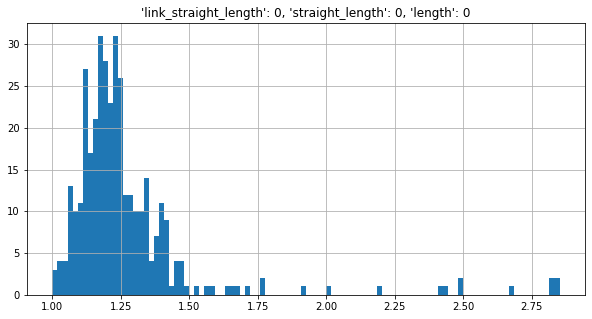

In [ ]:
ax = lines['length_ratio'].hist(bins=100, figsize=[10, 5])
ax.set_title(title)

In [ ]:
url = 'http://a.basemaps.cartocdn.com/light_nolabels/tile5/tile21/tile21.png'
url = 'http://a.basemaps.cartocdn.com/light_nolabels/tile21/tile21/tile5.png'

import matplotlib.pyplot as plt
def plot_networkcaster(raw, processed, figsize=[25, 25],url=None, *args, **kwargs):
    fig, ax = plt.subplots(2, 2,  figsize=figsize, tight_layout=True) 
    
    # print(0)
    buffer = raw.copy()
    # buffer_width = max(raw.zones['geometry'].apply(lambda g: max(abs(g.bounds[0]-g.bounds[2]), abs(g.bounds[1]-g.bounds[3]))))/2
    # buffer.zones['geometry'] = buffer.zones['geometry'].apply(lambda g: g.buffer(buffer_width))
    
    # print(1)
    # raw.road_nodes.plot(markersize=0.3, color='black', ax=ax.flat[0])
    raw.road_links.plot(linewidth=0.3, color='green', ax=ax.flat[0])
    ax.flat[0].set_title("Road network")
    
    # print(2)
    raw.links.plot(ax=ax.flat[1], color='blue', linewidth=0.5)
    gpd.GeoSeries(raw.nodes.geometry, crs=4326).plot(ax=ax.flat[1], color='black', markersize=10)
    gpd.GeoSeries(raw.disaggregated_nodes.geometry, crs=4326).plot(ax=ax.flat[1], color='pink', markersize=2)
    # if interested one could add disaggregated_nodes and connect them to center node.
    ax.flat[1].set_title("GTFS")

    # print(3)
    raw.road_links.plot(color='green', linewidth=0.5, ax=ax.flat[2])
    raw.links.plot(ax=ax.flat[2], color='blue', linewidth=0.2)
    ax.flat[2].set_title("raw GTFS & road network")

    # print(4)
    # gpd.GeoSeries(processed.road_links['geometry'], crs=4326).plot(ax=ax.flat[3], color='green', linewidth=0.5)
    # gpd.GeoSeries(processed.links['geometry'], crs=4326).plot(ax=ax.flat[3], color='blue', linewidth=0.5)
    processed.road_links.plot(ax=ax.flat[3], color='green', linewidth=0.5)
    processed.links.plot(ax=ax.flat[3], color='blue', linewidth=0.5)
    ax.flat[3].set_title("Processed GTFS & Road Network")
    
    # print(5)
    for _ax in ax.flat:
        _ax.set_xlim(buffer.zones['geometry'].total_bounds[0], buffer.zones['geometry'].total_bounds[2])
        _ax.set_ylim(buffer.zones['geometry'].total_bounds[1], buffer.zones['geometry'].total_bounds[3])

    return fig

In [ ]:
# check for broken GeoDataFrames
broken_gdf_keys = [key for key in both.__dict__.keys() if type(both.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in both.__dict__[key].columns]
print("Fixing:", broken_gdf_keys)
# fix broken GeoDataFrames
for key in broken_gdf_keys:
    both.__dict__[key] = gpd.GeoDataFrame(both.__dict__[key], crs=both.epsg)
broken_gdf_keys = [key for key in both.__dict__.keys() if type(both.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in both.__dict__[key].columns]
if len(broken_gdf_keys)>0:
    print("Broken GeoDataFrames:",broken_gdf_keys)
else:
    print("Successfully fixed.")

Fixing: ['footpaths', 'networkcaster_neighbors', 'networkcaster_road_access', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'node_clusters']
Successfully fixed.


could not add basemap: cannot identify image file <_io.BytesIO object at 0x00000280A9B3B4A0>


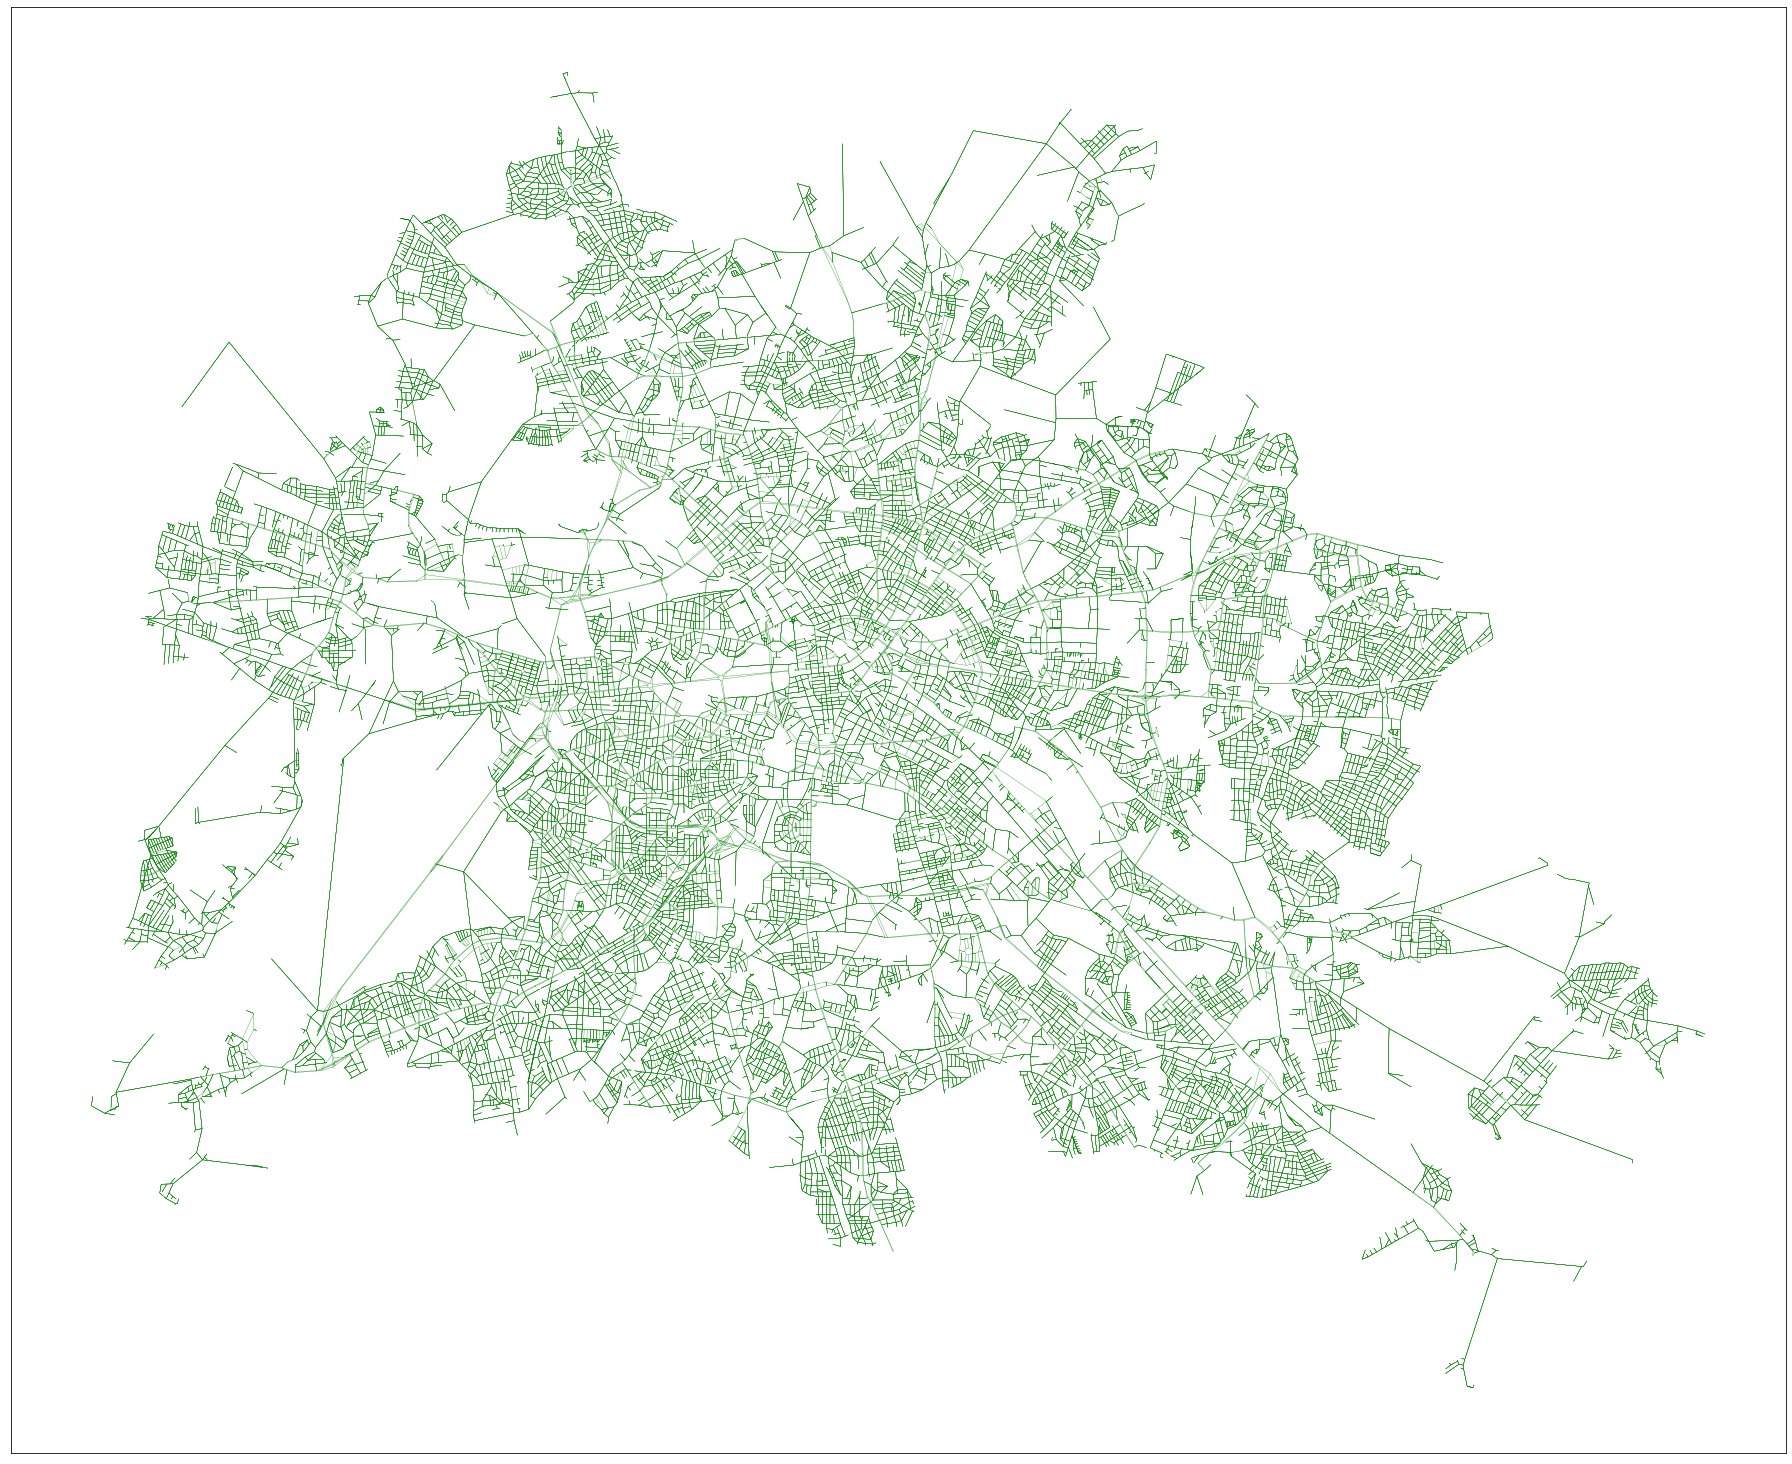

In [ ]:
if show_plots:
    fig, ax = plt.subplots(1, 1,  figsize=[25, 25], tight_layout=True) 
    url='http://a.basemaps.cartocdn.com/light_nolabels/tile4/tile16/tile11.png'
    url = 'http://a.basemaps.cartocdn.com/light_nolabels/tile5/tile21/tile21.png'
    url = 'http://a.basemaps.cartocdn.com/light_nolabels/tile17/tile21/tile5.png'
    url = 'http://a.basemaps.cartocdn.com/light_nolabels/tile1/tile1/tile1.png'

    buffer = sm.copy()
    buffer.zones['geometry'] = buffer.zones['geometry'].apply(lambda g: g.buffer(0.04))
    sm.plot('road_links', linewidth=0.3, color='green',
                    ax=ax, basemap_url=url
                    , figsize=[20,20])

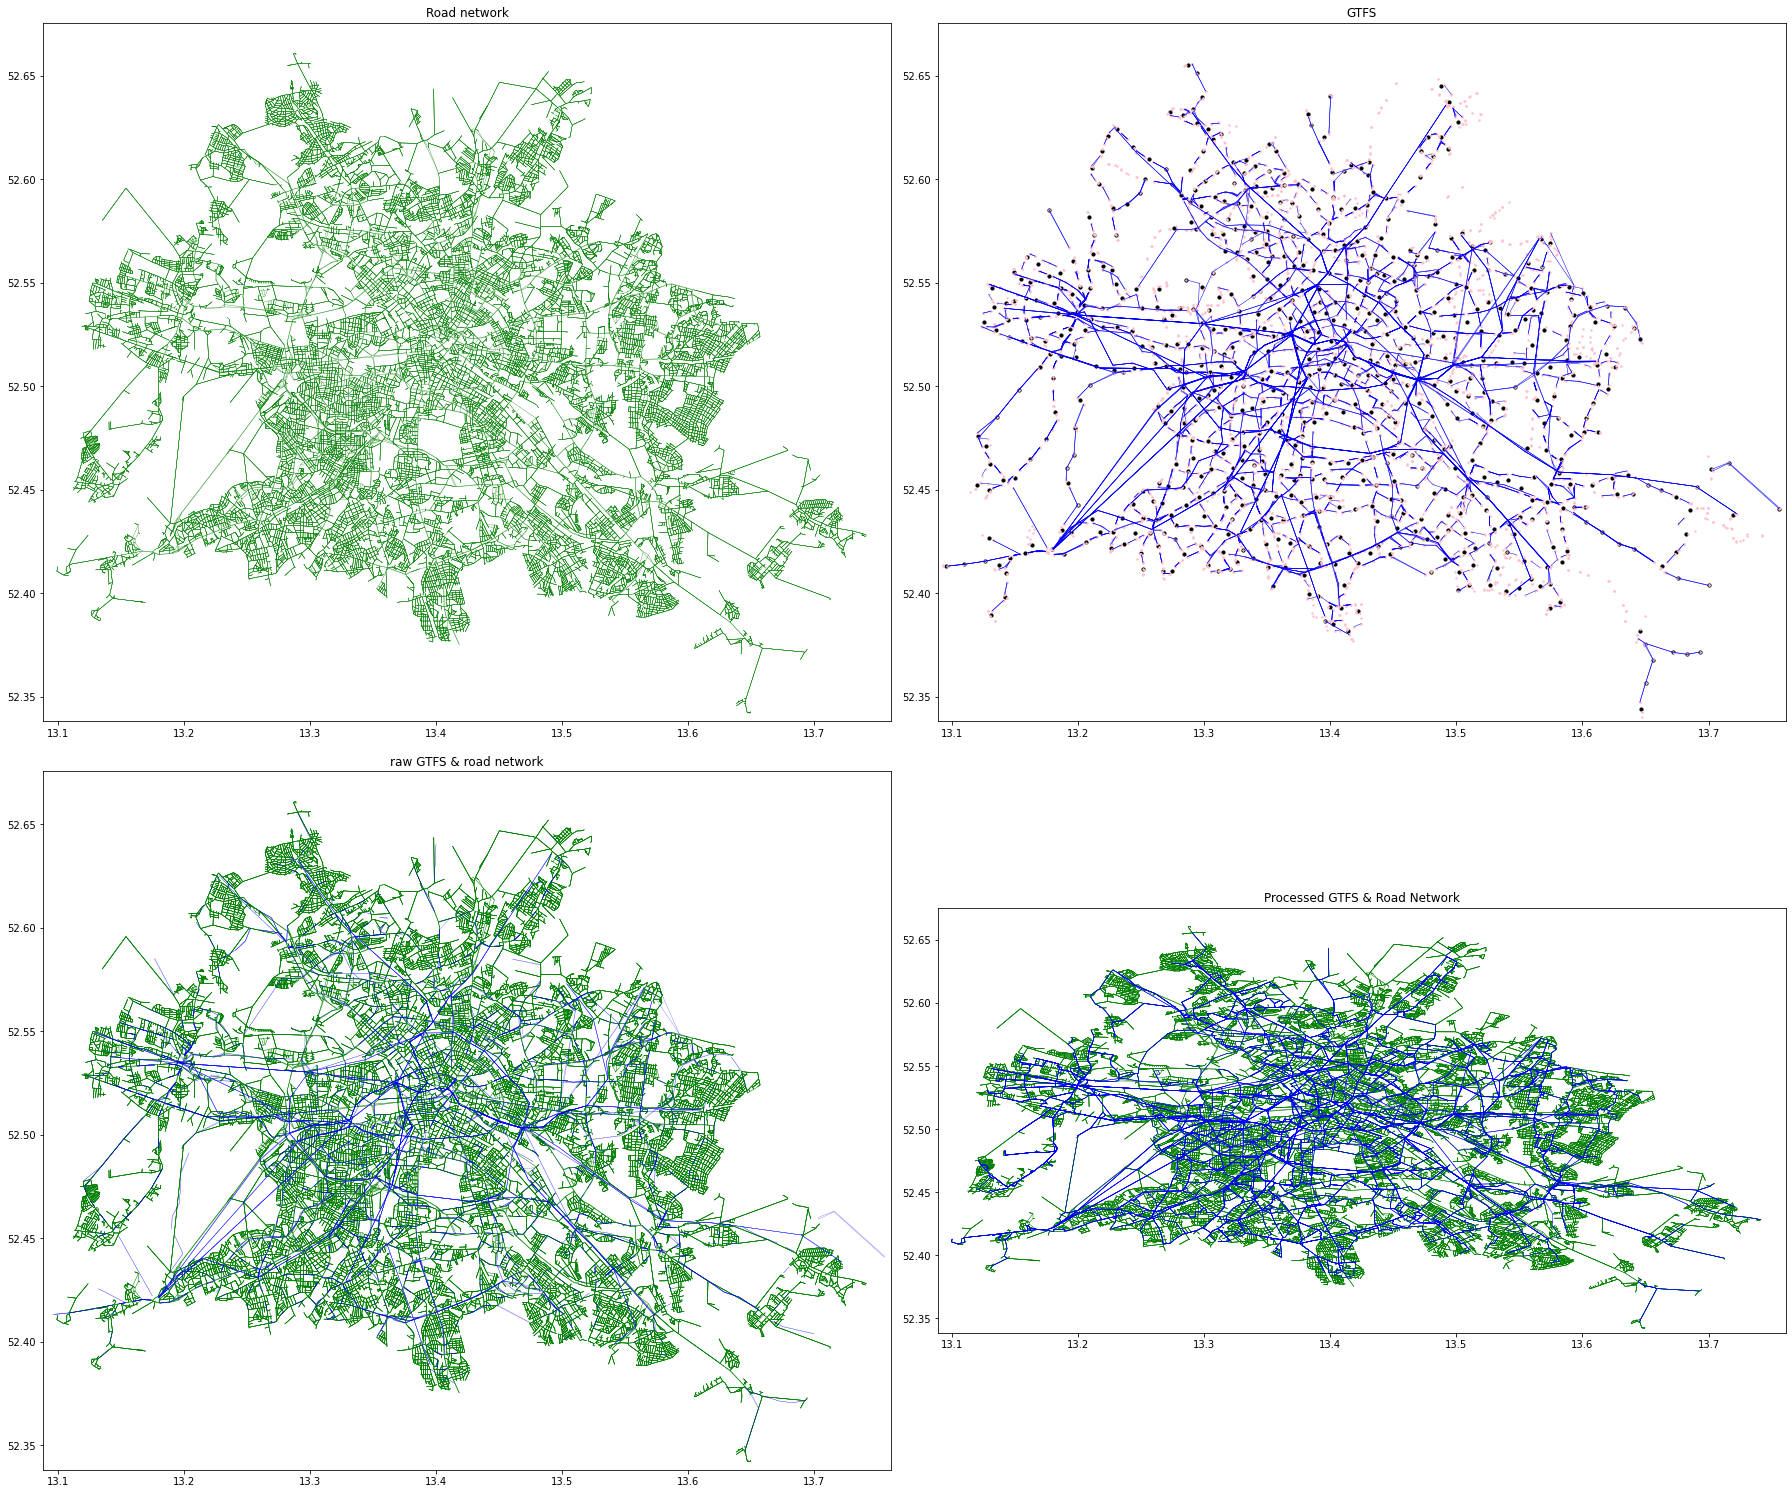

In [ ]:
if show_plots:
    fig = plot_networkcaster(raw=sm, processed=both, url=url)

## Add validation Data:

In [ ]:
sm = both

### read in validation data

link_id               elem_nr         vnp         nnp  vst  \
1051  50550011_50550037  50550011_50550037.01  50550011.0  50550037.0  0.0   

       bst vricht  ebene str_typ strklasse1 strklasse strklasse2     str_name  \
1051  69.0      B    0.0       S         IV         G       STRA  Thaerstraße   

      bezirk        stadtteil  dtvw_kfz  dtvw_lkw  \
1051  Pankow  Prenzlauer Berg    7400.0     150.0   

                                               geometry  
1051  LINESTRING (13.45588 52.52237, 13.45629 52.52293)

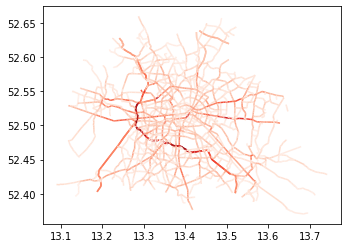

In [ ]:
traffic_validation = gpd.read_file(input_path + "validation/Verkehrsmengen.shp")
traffic_validation.to_crs(epsg=4326, inplace=True)
traffic_validation.plot(cmap="Reds", column='dtvw_kfz')
traffic_validation.sample(1)


## Match validation data to road network
- logic: create buffers around road_network and obtain intersection between the network polygons to match road links from validation data to road links from network
- for an even more accurate matching one could use the non-simplified links.

In [ ]:
def gridSearchIntersections (
        intersectionOf:GeoSeries, 
        intersectionWith:GeoSeries, 
        gridDimensions:tuple=(1,1), 
        outerBox:tuple=False,
        calc_margin_on:GeoSeries=None,
        plot:bool=True
        ) -> list:
    """
    Function that speeds up the search for an array of polygon within a GeoDataFrame
    returns GeoDataFrame with original geometry replaced with intersections geometry
    
    outerBox = (min_x, min_y, max_x, max_y)
    insideBufferInMeters should be at least circle radius around if looking for intersection of circles with something
    """
    if plot: print('Generate plots.')
    print('set up margins for grid search')
    t = datetime.now()

    if not type(outerBox) == tuple:
        outerBox = intersectionWith.total_bounds
    outerBoxPoly = Polygon([(outerBox[0], outerBox[1]), (outerBox[2], outerBox[1]), (outerBox[2], outerBox[3]), (outerBox[0], outerBox[3])])
    
    # continue here maybe use intersectionWith
    if not type(calc_margin_on) in (GeoSeries, GeoDataFrame):
        calc_margin_on = intersectionOf
    if not type(calc_margin_on) == GeoDataFrame:
        calc_margin_on = GeoDataFrame(geometry=calc_margin_on, crs=calc_margin_on.crs)
    
    # prepare margin
    m_prep = [[abs(t[0]-t[1]) for t in x.xy] for x in calc_margin_on['geometry']]
    calc_margin_on['x_ext'] = [x[0] for x in m_prep]
    calc_margin_on['y_ext'] = [x[1] for x in m_prep]
    
    dim_x, dim_y = gridDimensions[0], gridDimensions[1]
    # stepsize_x, stepsize_y = (outerBox[2]-outerBox[0]-2*margin_x)/dim_x,  (outerBox[3]-outerBox[1]-2*margin_y)/dim_y
    stepsize_x, stepsize_y = (outerBox[2]-outerBox[0])/dim_x,  (outerBox[3]-outerBox[1])/dim_y

    # xsteps = [margin_x+outerBox[0]+stepsize_x*(n) for n in range(dim_x+1)]
    # ysteps = [margin_y+outerBox[1]+stepsize_y*(n) for n in range(dim_y+1)]
    xsteps = [outerBox[0]+stepsize_x*(n) for n in range(dim_x+1)]
    ysteps = [outerBox[1]+stepsize_y*(n) for n in range(dim_y+1)]
    

    print('time spent to set up correct margins', datetime.now()-t)
    print("set up grid cells")

    grid = [[] for i in range(dim_x)]
    gridPolys = []
    t = datetime.now()
    for i in range(dim_x):
        if (100 * i / dim_x) % 20 == 0 and i > 0:
            print(round(100*i/ dim_x), "% Time remaining:", (datetime.now()-t)*(1- i/dim_x)/(i/ dim_x), 
            "% Time remaining:", (datetime.now()-t)*(1- i/dim_x)/(i/ dim_x),
            'Time elapsed:', datetime.now()-t)
        
        gridCol_of = calc_margin_on.cx[xsteps[i] : xsteps[i+1], : ]
        margin_x = gridCol_of['x_ext'].max() if len(gridCol_of)>0 else 0.0

        gridCol = intersectionWith.cx[xsteps[i]-margin_x : xsteps[i+1]+margin_x, : ]
        
        if len(gridCol)==0:
            grid[i].extend([gridCol for j in range(dim_y)])
            gridPolys.extend([Polygon([]) for j in range(dim_y)])
            continue

        for j in range(dim_y):

            gridCell_of = gridCol_of.cx[ : , ysteps[j] : ysteps[j+1]]
            margin_y = gridCell_of['y_ext'].max() if len(gridCell_of)>0 else 0.0
            gridCell = gridCol.cx[ : , ysteps[j]-margin_y : ysteps[j+1]+margin_y]
            grid[i].append(gridCell) 
            
            if plot:
                gridPolys.append(Polygon([\
                    (xsteps[i]-margin_x, ysteps[j]-margin_y), \
                    (xsteps[i]-margin_x, ysteps[j+1]+margin_y), \
                    (xsteps[i+1]+margin_x, ysteps[j+1]+margin_y), \
                    (xsteps[i+1]+margin_x, ysteps[j]-margin_y)\
                ]))
    
    print(datetime.now() - t, "time spent to set up grid cells",gridDimensions, '=',gridDimensions[0]*gridDimensions[1], '')

    t = datetime.now()

    intersection_df = intersectionOf.copy()
    intersections = []

    time_lookup = datetime.now()-datetime.now()
    time_intersection = datetime.now()-datetime.now()

    print('start creating intersections')
    len_io = len(intersectionOf)
    for n, geom in zip(range(len_io), list(intersectionOf)):
        if (n*100 / len_io) % 2 > ((n+1)*100 / len_io) % 2 and n > 0:
            print(round(100*n/ len_io), 
            "% Time remaining:", 
            (datetime.now()-t)*(1- n/len_io)/(n/ len_io),
            'Time elapsed:', datetime.now()-t,
            'total look_up time:', time_lookup,
            'total intersection time:', time_intersection)
        
        # geom = intersectionOf.iloc[n]
        t_ = datetime.now()
        centroidCoords = geom.centroid.coords[0]
        try:
            i = next(n for n,x in enumerate(xsteps) if x>centroidCoords[0]) -1
        except:
            i = -1
        try:
            j = next(n for n,y in enumerate(ysteps) if y>centroidCoords[1]) -1
        except:
            j = -1
        time_lookup += datetime.now()- t_

        t_ = datetime.now()
        intersection = [] if -1 in (i,j) and not geom.intersects(outerBoxPoly) else [(n,g) for n,g in zip(grid[i][j].index, grid[i][j].intersection(geom)) if not g.is_empty]
        intersection_areas = [(n, x.area) for n,x in intersection]
        intersection_union_area = unary_union([x for n,x in intersection]).area
        time_intersection += datetime.now()- t_
        intersections.append((intersection_areas, intersection_union_area))

        
    print(datetime.now() - t, "time spent to create intersection",len(intersectionOf),
            'total look_up time:', time_lookup,
            'total intersection time:', time_intersection)

    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))
        intersectionOf.plot(ax=ax, color="red", alpha=.3)
        intersectionWith.plot(ax=ax, color="blue", alpha=.3)
        GeoSeries([outerBoxPoly], crs=4326).plot(ax=ax, color="none", edgecolor="black", linewidth=2)
        GeoSeries(gridPolys, crs=4326).plot(ax=ax, facecolor="none", edgecolor="black", linewidth=.5)
    
    return intersections    

### choose buffer parameter
- the coice matters! 
- be as precise as possible (its better to have fewer validation data, than wrong validation data!)


#### Match validation data to sm.road_links

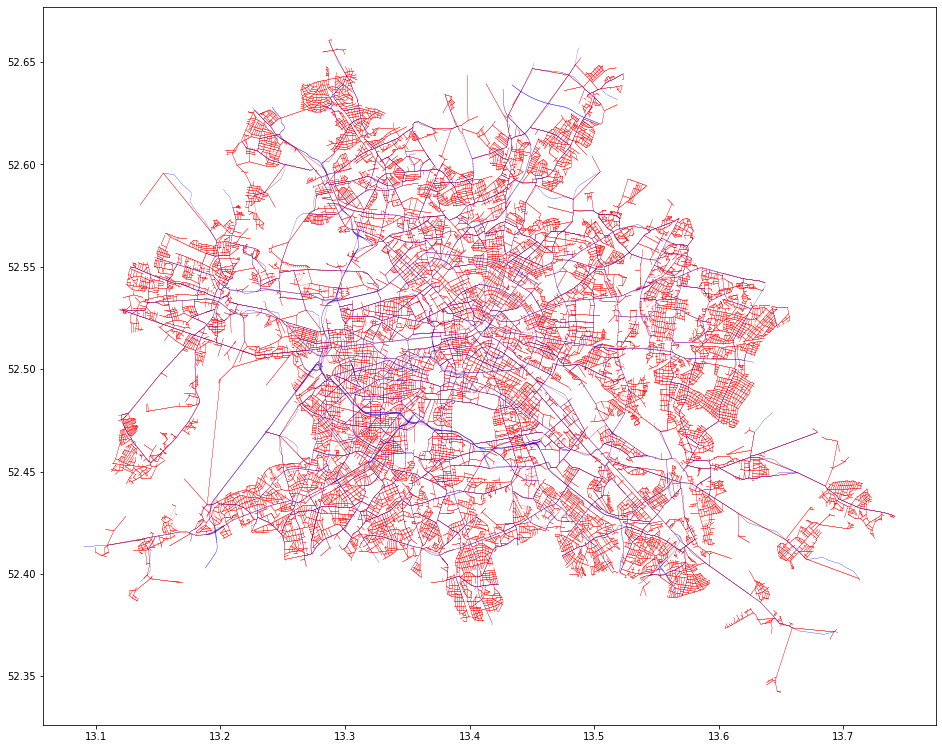

In [ ]:
# define the width of each polygon. the choice of this parameter matters! b
validation_buffer = 0.0001
# for each link in road network compute its validation traffic data by:
network_buff = sm.road_links.buffer(validation_buffer*.5)
validation_buff = traffic_validation.buffer(validation_buffer)


if show_plots:
    fig, ax = plt.subplots(figsize = (16,16))
    network_buff.plot(ax=ax, color="red")
    validation_buff.plot(ax=ax, color="blue", alpha=0.75)


In [ ]:
# for each link in road network with buffer calculate retrieve its intersection with validation data gdf
# its best to make the grid very fine so that grid creation and intersection time are balanced
# function still take over 10 Minutes.
road_links_validation_intersections = \
    gridSearchIntersections(
        intersectionOf=network_buff, 
        intersectionWith=validation_buff, 
        gridDimensions=(70,70), 
        calc_margin_on=sm.road_links['geometry'],
        plot=False
        )


set up margins for grid search
time spent to set up correct margins 0:00:09.573108
set up grid cells
20 % Time remaining: 0:01:02.843725 % Time remaining: 0:01:02.843725 Time elapsed: 0:00:15.710931
40 % Time remaining: 0:00:53.351732 % Time remaining: 0:00:53.351732 Time elapsed: 0:00:35.567821
60 % Time remaining: 0:00:39.038473 % Time remaining: 0:00:39.038473 Time elapsed: 0:00:58.557710
80 % Time remaining: 0:00:18.880860 % Time remaining: 0:00:18.880860 Time elapsed: 0:01:15.523441
0:01:30.549979 time spent to set up grid cells (70, 70) = 4900 
start creating intersections
2 % Time remaining: 0:19:22.504154 Time elapsed: 0:00:23.723859 total look_up time: 0:00:00.344904 total intersection time: 0:00:20.350807
4 % Time remaining: 0:16:39.986302 Time elapsed: 0:00:41.664813 total look_up time: 0:00:00.595803 total intersection time: 0:00:37.995871
6 % Time remaining: 0:15:22.125517 Time elapsed: 0:00:58.857225 total look_up time: 0:00:00.859689 total intersection time: 0:00:54.8884

(0.0, 1.0)

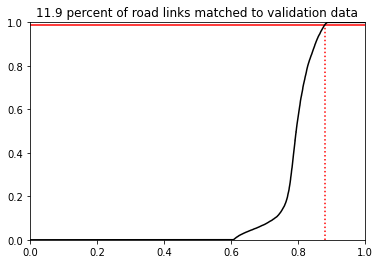

In [ ]:
# now weight the intersection by area / divide by total intersection number and multiply it with respective validation data point
# make sure that not every road that just touches a road with validation data at a crossing is treated as if it has validation data
# by adding a threshold of how large the  be at least
total_intersection_areas = [sum([y for n, y in x[0]]) for x in road_links_validation_intersections]
tvd = list(traffic_validation['dtvw_kfz'])

sm.road_links['validation_load'] = \
    [sum([x/t*tvd[n] for n,x in xsections]) \
    if xarea > (nb.area * 0) else 0 \
    for (xsections, xarea),t,nb in zip(road_links_validation_intersections, total_intersection_areas, network_buff)] 

sm.road_links['validation_share'] = [xarea/nb.area for (xsections, xarea), nb in zip(road_links_validation_intersections, network_buff)] 

threshold = 0.99
sm.road_links['validation_threshold'] = sm.road_links['validation_share'] > threshold

share = sum(sm.road_links['validation_threshold'])/len(sm.road_links)


plt.plot([x/len(sm.road_links) for x in range(len(sm.road_links))], sorted([(x[1]/nb.area) for x,t,nb in zip(road_links_validation_intersections, total_intersection_areas, network_buff)]), 'k')
plt.hlines(threshold, 0, 1, linestyles ="solid", colors ="red")
plt.vlines(1-share, 0, threshold, linestyles ="dotted", colors ="red")
plt.title(str(round(share*100,1)) + ' percent of road links matched to validation data')
plt.xlim((0,1))
plt.ylim((0,1))

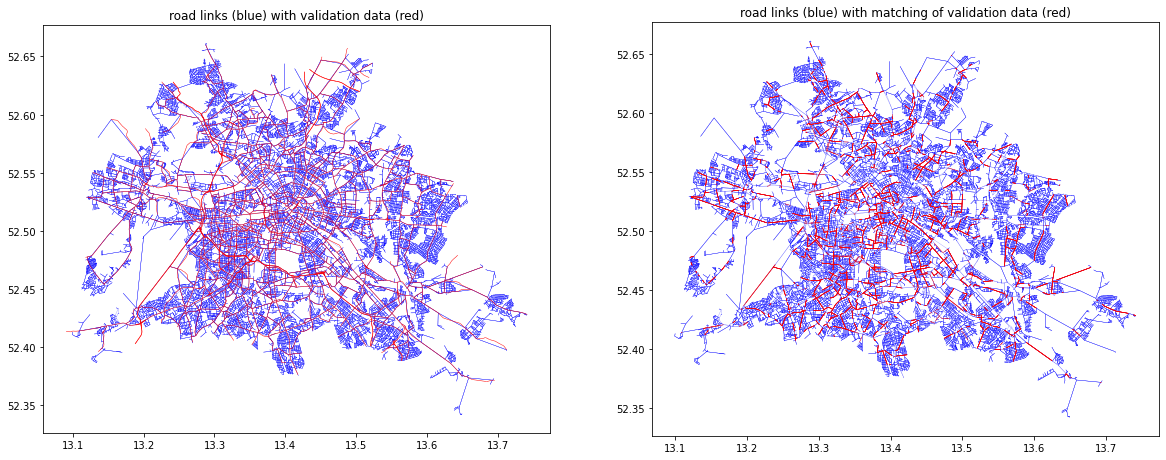

In [ ]:
if show_plots:
    fig, ax = plt.subplots(ncols=2, figsize = (20,16))

    sm.road_links.plot(ax=ax.flat[0], color="blue", alpha=.5, linewidth=.3)
    traffic_validation.plot(ax=ax.flat[0], color="red", linewidth=0.5)
    # network_buff.plot(ax=ax.flat[0], color="blue", alpha=.5, linewidth=0.5)
    # validation_buff.plot(ax=ax.flat[0], color="red", linewidth=0.5)
    ax.flat[0].set_title('road links (blue) with validation data (red)')

    sm.road_links.plot(ax=ax.flat[1], color="blue", alpha=.5, linewidth=.3)
    sm.road_links[sm.road_links['validation_threshold']].plot(ax=ax.flat[1], color="red", linewidth=0.5)
    # network_buff.plot(ax=ax.flat[1], color="blue", alpha=.5, linewidth=0.5)
    # network_buff[sm.road_links['validation_threshold']].plot(ax=ax.flat[1], color="red", linewidth=0.5)
    ax.flat[1].set_title('road links (blue) with matching of validation data (red)')



#### Match validation data to sm.loaded_links

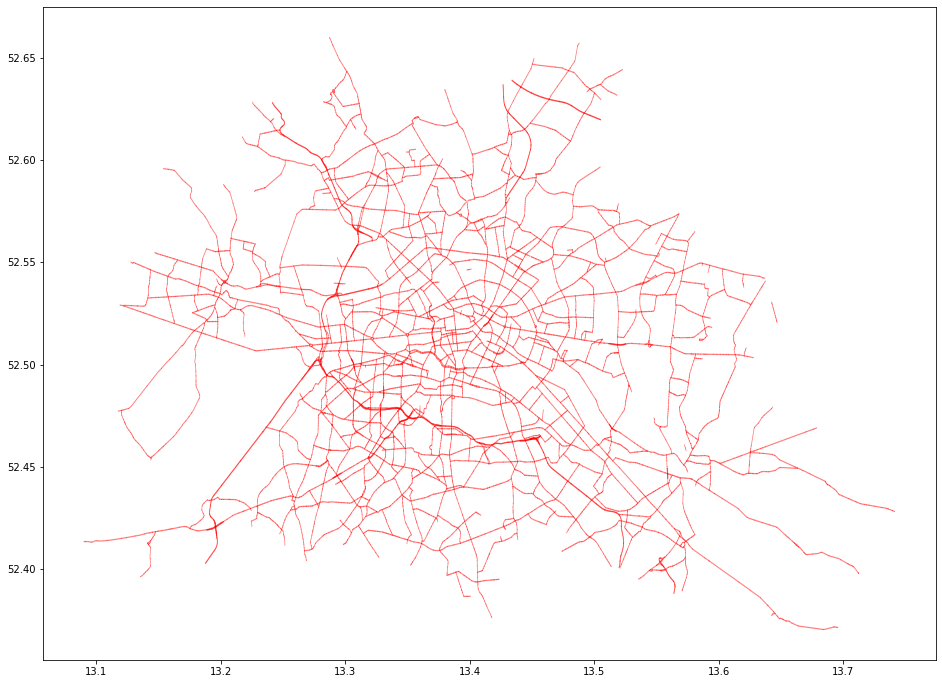

In [ ]:
# validation_buffer = 0.0003
# # for each link in road network compute its validation traffic data by:
# network_buff = sm.loaded_links.buffer(validation_buffer*.5)
# validation_buff = traffic_validation.buffer(validation_buffer)

# if show_plots:
#     fig, ax = plt.subplots(figsize = (16,16))
#     network_buff.plot(ax=ax, color="blue")
#     validation_buff.plot(ax=ax, color="red", alpha=0.5)


In [ ]:
# # for each link in road network with buffer calculate retrieve its intersection with validation data gdf
# # its best to make the grid very fine so that grid creation and intersection time are balanced
# # function still take over 10 Minutes.
# loaded_links_validation_intersections = \
#     gridSearchIntersections(
#         intersectionOf=network_buff, 
#         intersectionWith=validation_buff, 
#         gridDimensions=(25,15), 
#         calc_margin_on=sm.loaded_links['geometry'],
#         plot=False
#         )


(0.0, 1.0)

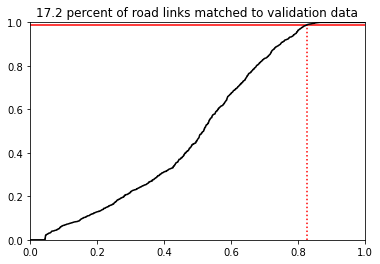

In [ ]:
# # now weight the intersection by area / divide by total intersection number and multiply it with respective validation data point
# # make sure that not every road that just touches a road with validation data at a crossing is treated as if it has validation data
# # by adding a threshold of how large the  be at least
# threshold = 0.99
# total_intersection_areas = [sum([y for n, y in x[0]]) for x in loaded_links_validation_intersections]
# tvd = list(traffic_validation['dtvw_kfz'])

# sm.loaded_links['validation_load'] = \
#     [sum([x/t*tvd[n] for n,x in xsections]) \
#     if xarea > (nb.area * 0) else 0 \
#     for (xsections, xarea),t,nb in zip(loaded_links_validation_intersections, total_intersection_areas, network_buff)] 

# sm.loaded_links['validation_share'] = [xarea/nb.area for (xsections, xarea), nb in zip(loaded_links_validation_intersections, network_buff)] 
# sm.loaded_links['validation_threshold'] = sm.loaded_links['validation_share'] > threshold

# share = sum(sm.loaded_links['validation_threshold'])/len(sm.loaded_links)


# plt.plot([x/len(sm.loaded_links) for x in range(len(sm.loaded_links))], sorted([(x[1]/nb.area) for x,t,nb in zip(loaded_links_validation_intersections, total_intersection_areas, network_buff)]), 'k')
# plt.hlines(threshold, 0, 1, linestyles ="solid", colors ="red")
# plt.vlines(1-share, 0, threshold, linestyles ="dotted", colors ="red")
# plt.title(str(round(share*100,1)) + ' percent of road links matched to validation data')
# plt.xlim((0,1))
# plt.ylim((0,1))

Text(0.5, 1.0, 'loaded links (blue) with matching of validation data (red)')

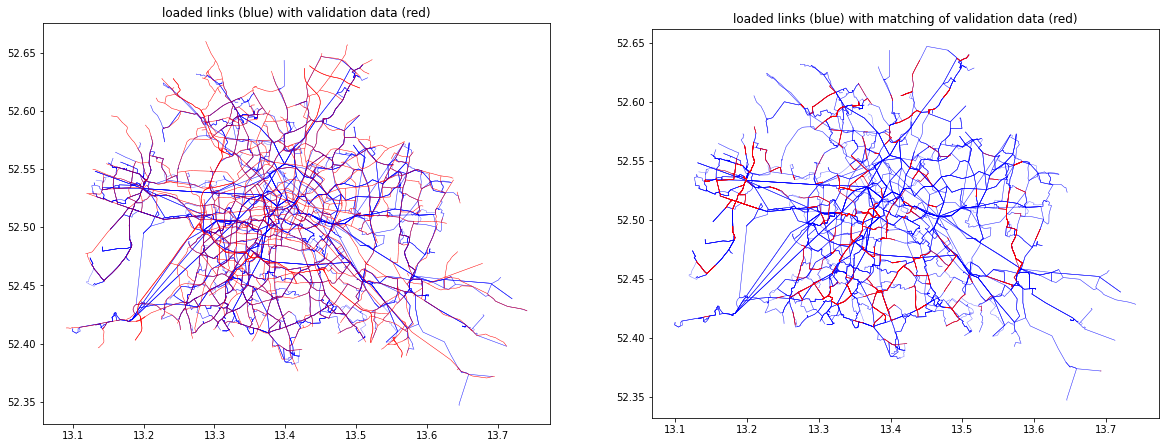

In [ ]:
# fig, ax = plt.subplots(ncols=2, figsize = (20,16))

# sm.loaded_links.plot(ax=ax.flat[0], color="blue", alpha=.5, linewidth=0.5)
# traffic_validation.plot(ax=ax.flat[0], color="red", linewidth=0.5)
# # network_buff.plot(ax=ax.flat[0], color="blue", alpha=.5, linewidth=0.5)
# # validation_buff.plot(ax=ax.flat[0], color="red", linewidth=0.5)
# ax.flat[0].set_title('loaded links (blue) with validation data (red)')

# sm.loaded_links.plot(ax=ax.flat[1], color="blue", alpha=.5, linewidth=0.5)
# sm.loaded_links[sm.loaded_links['validation_threshold']].plot(ax=ax.flat[1], color="red", linewidth=0.5)
# # network_buff.plot(ax=ax.flat[1], color="blue", alpha=.5, linewidth=0.5)
# # network_buff[sm.loaded_links['validation_threshold']].plot(ax=ax.flat[1], color="red", linewidth=0.5)
# ax.flat[1].set_title('loaded links (blue) with matching of validation data (red)')



(0.0, 1.0)

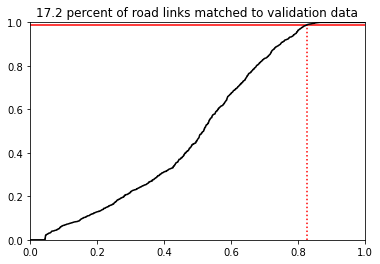

In [ ]:
# # now weight the intersection by area / divide by total intersection number and multiply it with respective validation data point
# # make sure that not every road that just touches a road with validation data at a crossing is treated as if it has validation data
# # by adding a threshold of how large the  be at least
# threshold = 0.99
# total_intersection_areas = [sum([y for n, y in x[0]]) for x in loaded_links_validation_intersections]
# tvd = list(traffic_validation['dtvw_kfz'])

# sm.loaded_links['validation_load'] = \
#     [sum([x/t*tvd[n] for n,x in xsections]) \
#     if xarea > (nb.area * 0) else 0 \
#     for (xsections, xarea),t,nb in zip(loaded_links_validation_intersections, total_intersection_areas, network_buff)] 

# sm.loaded_links['validation_threshold'] = [xarea > (nb.area * threshold) for (xsections, xarea), nb in zip(loaded_links_validation_intersections, network_buff)] 

# share = sum(sm.loaded_links['validation_threshold'])/len(sm.loaded_links)


# plt.plot([x/len(sm.loaded_links) for x in range(len(sm.loaded_links))], sorted([(x[1]/nb.area) for x,t,nb in zip(loaded_links_validation_intersections, total_intersection_areas, network_buff)]), 'k')
# plt.hlines(threshold, 0, 1, linestyles ="solid", colors ="red")
# plt.vlines(1-share, 0, threshold, linestyles ="dotted", colors ="red")
# plt.title(str(round(share*100,1)) + ' percent of road links matched to validation data')
# plt.xlim((0,1))
# plt.ylim((0,1))

In [ ]:
# We can drastically reduce the disc space needed for this table by
# reducing the complexity of LineString geometries.
# For our purpose it is enough to have the start and end point of a link.
# Let's write a function
def simplify_link(g):
    l = list(g.coords)
    return LineString([l[0], l[-1]])
# Apply the function to all our links
# road_links['geometry'] = road_links['geometry'].apply(simplify_link)
sm.road_links['geometry'] = sm.road_links['geometry'].apply(simplify_link)

## Save the model

We have a complete network with connectors. Now save it.

quetzal provides two functions. One is the to_zip (and read_zip for loading again), which is very fast, but the file format is hdf5, which is not compatible with other programs.

The other option is to_json (and read_json), which saves tables as GeoJSON format. This is great to look at them in GIS software like QGIS, but it is slower for larger models.

Both functions take the location string as a first argument and optionally the only_attributes argument, where you can pass a list of table names that should be saved. All others are discarded.

In [ ]:
sm.to_json('../../model/network')

to_hdf(overwriting): 100%|██████████| 40/40 [01:03<00:00,  1.58s/it]

could not save geometry from table fare_rules
could not save geometry from table fare_attributes
could not save geometry from table mode_nests
could not save geometry from table logit_scales
could not save geometry from table utility_values
could not save geometry from table jsons
could not save attribute: missing_road_nodes
could not save attribute: missing_nodes
could not save attribute: orphan_nodes
could not save attribute: networkcaster
